# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [89]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score,fbeta_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore Data Analysis  

In [90]:
# we see portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [91]:
# check null data
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [92]:
# stats portfolio
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


As seen channels column is category so we will break down it

In [93]:
def santinize_portfolio(portfolio):
    '''
    Santinizing the portfolio dataset
    
    INPUT:
    portfolio - the dataframe to be santinized
    
    OUTPUT:
    santinized_portfolio - the santinized portfolio dataframe
    
    '''
    santinized_portfolio = portfolio.copy()
    
    # convert  duration in hours 
    santinized_portfolio['duration'] = santinized_portfolio['duration'] * 24
    
    # convert channels category into other fields
    santinized_portfolio['web'] = santinized_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    santinized_portfolio['email'] = santinized_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    santinized_portfolio['mobile'] = santinized_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    santinized_portfolio['social'] = santinized_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # replace id to offer_id
    santinized_portfolio.rename(columns={'id':'offer_id'},inplace=True)
        
    # drop channels
    santinized_portfolio.drop(['channels'],axis=1,inplace=True)
    
    return santinized_portfolio

santinized_portfolio = santinize_portfolio(portfolio)

In [94]:
santinized_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [95]:
santinized_portfolio.isnull().sum()

difficulty    0
duration      0
offer_id      0
offer_type    0
reward        0
web           0
email         0
mobile        0
social        0
dtype: int64

In [96]:
print(santinized_portfolio.shape)
santinized_portfolio.drop_duplicates()

(10, 9)


,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [97]:
# Profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [98]:
# we see some NaN values there.
# Stats the profile
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [99]:
# check null data
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [105]:
# we would check gender, age, income columns for age 118, it seems this one is too old as common??? :D
print("Number of Customers that have 118 years old is:  ", profile[profile.age == 118][['gender','age','income']].shape[0])

Number of Customers that have 118 years old is:   2175


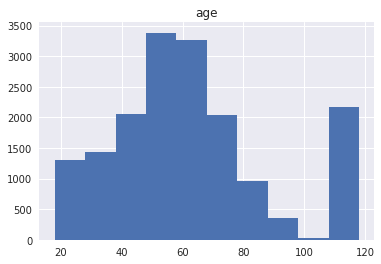

In [106]:
# As seen, this is fake data and abnormal case, we should santinize this data
profile.hist(column='age');

In [124]:
def santinize_profile(profile):
    '''
    Santinizing the profile dataset
    
    INPUT:
    profile - the profile dataframe
    
    OUTPUT:
    santinize_profile - the santinized transcript dataframe
    
    '''
    santinize_profile = profile.copy()
    
    # age: (numeric) missing value of 118
    santinize_profile['age'] = santinize_profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    santinize_profile.dropna(inplace=True)
    
    # convert to datetime
    santinize_profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")
    
    
    # add Age_group column
    santinize_profile.loc[(santinize_profile.age < 20) , 'Age_group'] = 'Under-20'
    santinize_profile.loc[(santinize_profile.age >= 20) & (santinize_profile.age <= 45) , 'Age_group'] = '20-45'
    santinize_profile.loc[(santinize_profile.age >= 46) & (santinize_profile.age <= 60) , 'Age_group'] = '46-60'
    santinize_profile.loc[(santinize_profile.age >= 61) & (santinize_profile.age <= 80) , 'Age_group'] = '61-80'
    santinize_profile.loc[(santinize_profile.age >= 81) , 'Age_group'] = '81-101'
    
    # dividing into income range
    santinize_profile.loc[(santinize_profile.income <= 45000) , 'income_range'] = '30k - 45k',
    santinize_profile.loc[(santinize_profile.income >= 45001) & (santinize_profile.income <= 60000), 
                          'income_range'] = '45k - 60k'
    santinize_profile.loc[(santinize_profile.income >= 60001) & (santinize_profile.income <= 75000) ,
                          'income_range'] = '60k - 75k'
    santinize_profile.loc[(santinize_profile.income >= 75001) & (santinize_profile.income <= 90000) ,
                          'income_range'] = '75k - 90k'
    santinize_profile.loc[(santinize_profile.income >= 90001) & (santinize_profile.income <= 105000) ,
                          'income_range'] = '90k - 105k'
    santinize_profile.loc[(santinize_profile.income >= 105001) & (santinize_profile.income <= 120000) ,
                          'income_range'] ='105k - 120k'
    
     # make the membership columns
    santinize_profile['membership_year'] = santinize_profile.became_member_on.dt.year
    santinize_profile['membership_month'] = santinize_profile.became_member_on.dt.month
    santinize_profile['membership_day'] = santinize_profile.became_member_on.dt.day
    
    # replace id to offer_id
    santinize_profile.rename(columns={'id':'customer_id'},inplace=True)   
    
    
    return santinize_profile

santinized_profile = santinize_profile(profile)

In [125]:
santinized_profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
Age_group           0
income_range        0
membership_year     0
membership_month    0
membership_day      0
dtype: int64

In [126]:
# new santinized profile data
santinized_profile.head()

,age,became_member_on,gender,customer_id,income,Age_group,income_range,membership_year,membership_month,membership_day
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,61-80,60k - 75k,2018,4,26
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,61-80,45k - 60k,2018,2,9
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,46-60,45k - 60k,2017,11,11


well, it looks better and meaningful now!

In [128]:
# transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [129]:
def santinize_transcript(transcript):
    '''
    Santinizing the transcript dataset
    
    INPUT:
    transcript - the transcript dataframe
    
    OUTPUT:
    transcript - the santinized transcript dataframe
    '''
    transcript_tmp = transcript.copy()
    transcript_tmp = pd.concat([transcript_tmp, transcript_tmp['value'].apply(pd.Series)], axis=1)

    # clean up the offer id ,offer_id then meger into one column 
    transcript_tmp['offer_clean'] = np.where(transcript_tmp['offer id'].isnull() & transcript_tmp['offer_id'].
                                             notnull(), transcript_tmp['offer_id'],transcript_tmp['offer id'])
    
    # drop the offer columns
    transcript_tmp.drop(['offer id', 'offer_id','value'], axis=1, inplace=True)

    # rename the off_clean column
    transcript_tmp.rename(columns={'offer_clean': 'offer_id'}, inplace=True)
   
    # rename the reward column
    transcript_tmp.rename(columns={'reward': 'money_got'}, inplace=True)
    
    # rename the person column to customer id
    transcript_tmp.rename(columns={'person': 'customer_id'}, inplace=True)
    
    #replace nan
    transcript_tmp.fillna(0 , inplace=True)
    
    return transcript_tmp

santinized_transcript = santinize_transcript(transcript)

In [130]:
# new transcript data
santinized_transcript.head()

,event,customer_id,time,amount,money_got,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [131]:
# now it's seems fine
santinized_transcript.isnull().sum()

event          0
customer_id    0
time           0
amount         0
money_got      0
offer_id       0
dtype: int64

In [134]:
print("Transcipt data origin: ", santinized_transcript.shape[0])
print("Transcipt data after removing dupcalied items: ", santinized_transcript.drop_duplicates().shape[0])

Transcipt data origin:  306534
Transcipt data after removing dupcalied items:  306137


It looks like transcript data has duplicated rows

We will explore some aspect of the data. But first of all we need to merge all the data into one

In [135]:
def merge_data(santinize_portfolio, santinize_profile, santinize_transcript):
    """
    Merge santinized dataframes
       
    Parameters
    ---------- 
    portfolio : santinized portfolio data frame
    profile : santinized profile data frame
    transcript : santinized transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(santinized_profile, santinized_transcript, on='customer_id')
    merged_df = pd.merge(merged_df,santinized_portfolio, on='offer_id')
    
    
    return merged_df

merged_df = merge_data(santinized_portfolio, santinized_profile, santinized_transcript)

In [136]:
# all merged data
merged_df.head()

,age,became_member_on,gender,customer_id,income,Age_group,income_range,membership_year,membership_month,membership_day,...,money_got,offer_id,difficulty,duration,offer_type,reward,web,email,mobile,social
0,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60,105k - 120k,2017,7,15,...,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
2,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0
4,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80,90k - 105k,2017,5,9,...,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,bogo,5,1,1,1,0


In [36]:
merged_df.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
Age_group           0
income_range        0
membership_year     0
membership_month    0
membership_day      0
event               0
time                0
amount              0
money_got           0
offer_id            0
difficulty          0
duration            0
offer_type          0
reward              0
web                 0
email               0
mobile              0
social              0
dtype: int64

### 1. Average age of Starbucks customers

In [137]:
profile['age'].mean()

62.531411764705879

So average people with 62 year-old go to Starbucks for coffee. Is that real???

### 2. Income for each gender

In [138]:
merged_df['income'].mean()

66414.119149222141

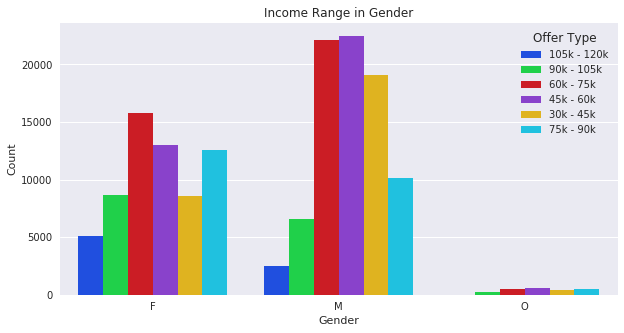

In [139]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "gender", hue= "income_range", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Income Range in Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')

### 3. Distribution of customers's Age

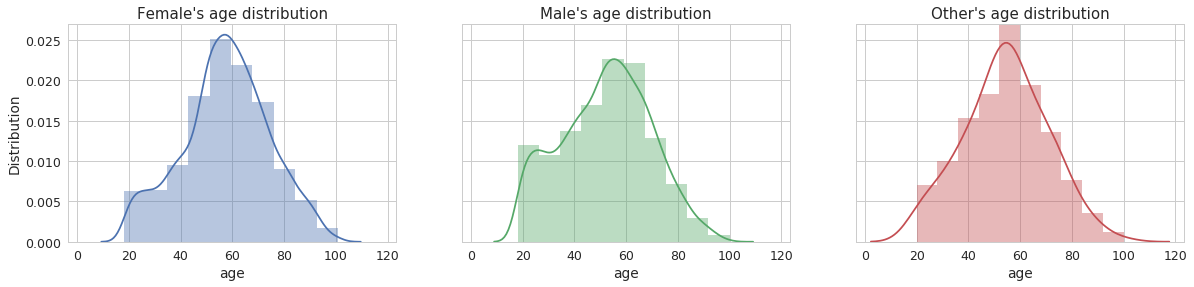

In [140]:
def plot_profile(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plt - basic histogram and density plot
    
    ''' 
    sns.set(style = 'whitegrid', font_scale = 1.25)
    palette = sns.color_palette()
    fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)
    
    plt.sca(ax[0])
    sns.distplot(df[df['gender'] == 'F'][variable], bins = 10, color = palette[0]);
    plt.title('Female\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.ylabel('Distribution')

    plt.sca(ax[1])
    sns.distplot(df[df['gender'] == 'M'][variable], bins = 10, color = palette[1]);
    plt.title('Male\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')

    plt.sca(ax[2])
    sns.distplot(df[df['gender'] == 'O'][variable], bins = 10, color = palette[2]);
    plt.title('Other\'s {} distribution'.format(variable))
    plt.xlabel(f'{variable}')
    plt.show()
    
    return plt
age_plot = plot_profile(profile, 'age')


### 4. Number of each Offer type

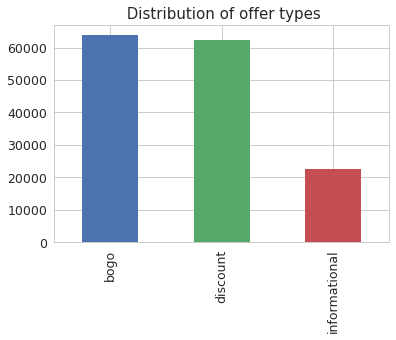

In [141]:
merged_df['offer_type'].value_counts().plot.bar(title=' Distribution of offer types')

### 5. Gender in each Offer

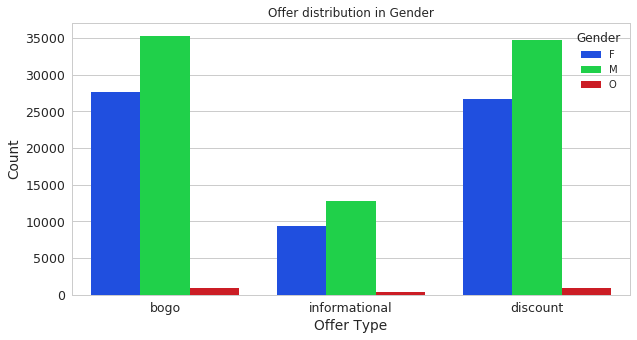

In [142]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "offer_type", hue= "gender", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Offer distribution in Gender')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

### 6. Customer reponse offer via web

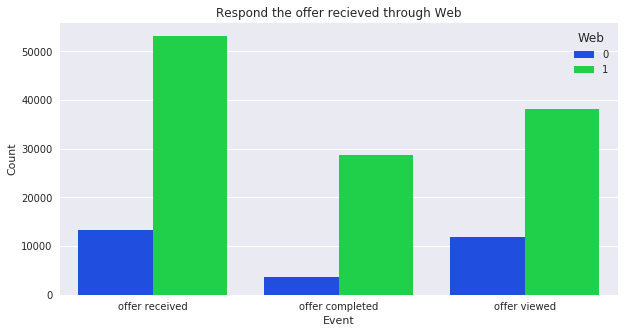

In [143]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "web", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through Web')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Web')

### 7. Customer reponse offer via mobile

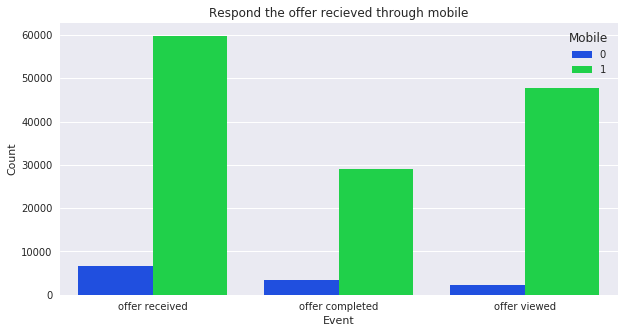

In [144]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "mobile", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through mobile')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Mobile')


### 8. Customer reponse offer via email

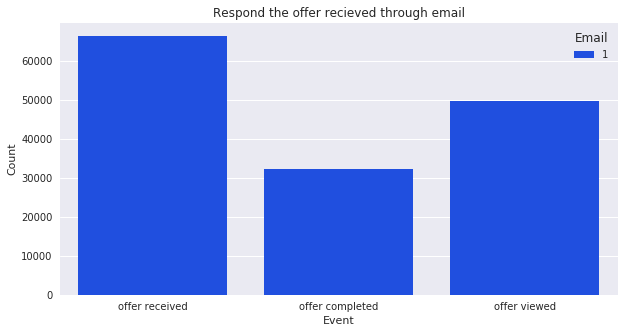

In [145]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "email", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through email')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Email')

### 9. Customer reponse offer via social

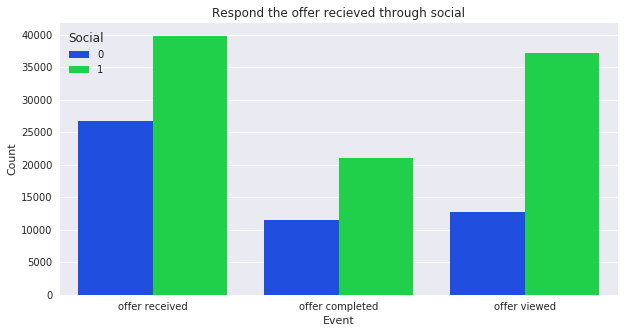

In [146]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "event", hue= "social", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Respond the offer recieved through social')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Social')

### 10. Offer status in Gender

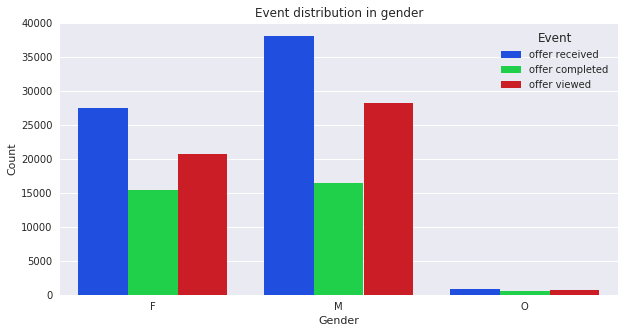

In [147]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "gender", hue= "event", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Event distribution in gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Event')

### 11. Events in income range

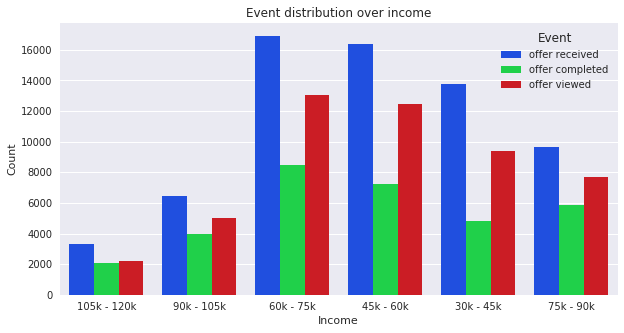

In [148]:
plt.figure(figsize=(10, 5))
sns.countplot(x= "income_range", hue= "event", data=merged_df, palette=sns.color_palette("bright", 10))
sns.set(style="darkgrid")
plt.title('Event distribution over income')
plt.ylabel('Count')
plt.xlabel('Income')
plt.legend(title='Event')

### 12. Distribution of Customer's Gender

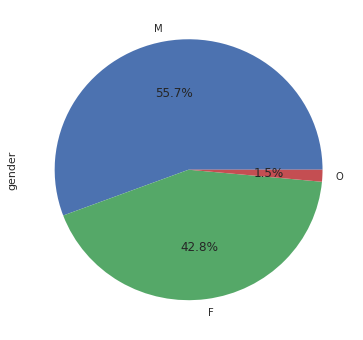

In [149]:
merged_df.gender.value_counts().plot(kind='pie' , figsize=(6, 6), autopct='%1.1f%%')

## Model Building

#### Data preparation

In [150]:
# santinizing the data for model building
def santinize_data(df):
    """
    Santinize dataframe  .
    
    Parameters
    ----------
    df: input data frame(profile,transcript,profile)
    
    Returns
    -------
    santinized_df: santinized dataframe
       
    """
    santinized_df = df.copy()
    
    # process categorical variables
    categorical = ['offer_type', 'gender']
    santinized_df = pd.get_dummies(santinized_df, columns = categorical)
    
    # drop no need data column
    santinized_df.drop(['became_member_on','income_range','Age_group','membership_month','membership_day'],axis=1, inplace=True)    
    
    # process offer_id column
    offer_ids = santinized_df['offer_id'].unique().tolist()
    of_mapping = dict( zip(offer_ids,range(len(offer_ids))) )
    santinized_df.replace({'offer_id': of_mapping},inplace=True)
    
    # process customer_id column
    cust_ids = santinized_df['customer_id'].unique().tolist()
    ct_mapping = dict( zip(cust_ids,range(len(cust_ids))) )
    santinized_df.replace({'customer_id': ct_mapping},inplace=True)
    
    
    # normalizing the data and process numerical variables

    scaler = MinMaxScaler() 
    numerical = ['income', 'difficulty', 'duration', 'reward','money_got', 'time','age']
    santinized_df[numerical] = scaler.fit_transform(santinized_df[numerical])
    
    # convert 'event' data to numerical values
    santinized_df['event'] = santinized_df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
   
    return santinized_df

santinized_df = santinize_data(merged_df)

In [151]:
# get first 5 rows
santinized_df.head()

,age,customer_id,income,membership_year,event,time,amount,money_got,offer_id,difficulty,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,0.445783,0,0.911111,2017,1,0.571429,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
1,0.445783,0,0.911111,2017,3,0.739496,0.0,0.5,0,0.25,...,1,1,1,0,1,0,0,1,0,0
2,0.686747,1,0.777778,2017,1,0.000000,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
3,0.686747,1,0.777778,2017,2,0.008403,0.0,0.0,0,0.25,...,1,1,1,0,1,0,0,1,0,0
4,0.686747,1,0.777778,2017,3,0.184874,0.0,0.5,0,0.25,...,1,1,1,0,1,0,0,1,0,0


In [152]:
# stats the data
santinized_df.describe()

,age,customer_id,income,membership_year,event,time,amount,money_got,offer_id,difficulty,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,...,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000
mean,0.443124,7292.622177,0.404601,2016.576365,1.771130,0.496597,0.0,0.107887,4.706703,0.394528,...,0.806747,1.0,0.917160,0.658311,0.428978,0.418743,0.152280,0.428205,0.557078,0.014717
std,0.207151,4264.461987,0.238855,1.186534,0.782658,0.277747,0.0,0.245254,2.796607,0.252067,...,0.394851,0.0,0.275641,0.474277,0.494932,0.493355,0.359293,0.494820,0.496733,0.120419
min,0.000000,0.000000,0.000000,2013.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301205,3570.000000,0.233333,2016.000000,1.000000,0.235294,0.0,0.000000,3.000000,0.250000,...,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.457831,7252.000000,0.388889,2017.000000,2.000000,0.571429,0.0,0.000000,5.000000,0.500000,...,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.590361,11021.000000,0.566667,2017.000000,2.000000,0.714286,0.0,0.000000,7.000000,0.500000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,14819.000000,1.000000,2018.000000,3.000000,1.000000,0.0,1.000000,9.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [153]:
# columns
santinized_df.columns

Index(['age', 'customer_id', 'income', 'membership_year', 'event', 'time',
       'amount', 'money_got', 'offer_id', 'difficulty', 'duration', 'reward',
       'web', 'email', 'mobile', 'social', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'gender_F',
       'gender_M', 'gender_O'],
      dtype='object')

In [154]:
# data size
santinized_df.shape

(148805, 22)

### Metrics

Since we have a simple classification problem, we will use accuracy to evaluate the models. We want to see how well our model by seeing the number of correct predictions vs total number of predicitons.

In [155]:
X = santinized_df.drop('event', axis=1)
y = santinized_df['event']

In [156]:
print(X.shape)
print(y.shape[0])

(148805, 21)
148805


In [157]:
# Start to split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
X_train.head()

,age,customer_id,income,membership_year,time,amount,money_got,offer_id,difficulty,duration,...,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
2211,0.337349,850,0.477778,2015,0.260504,0.0,0.5,0,0.25,0.571429,...,1,1,1,0,1,0,0,1,0,0
139542,0.301205,2347,0.466667,2018,0.470588,0.0,0.0,9,0.50,0.285714,...,1,1,1,1,1,0,0,0,1,0
130552,0.349398,13795,0.288889,2016,0.596639,0.0,0.5,8,1.00,1.000000,...,1,1,0,0,0,1,0,1,0,0
100404,0.385542,4985,0.488889,2015,0.571429,0.0,0.0,6,0.50,1.000000,...,1,1,1,1,0,1,0,0,1,0
109941,0.289157,10191,0.388889,2018,0.571429,0.0,0.0,7,0.35,0.571429,...,1,1,1,1,0,1,0,0,1,0


In [159]:

print("Training set: {} rows".format(X_train.shape[0]))
print("Test set: {} rows".format(X_test.shape[0]))

Training set: 119044 rows
Test set: 29761 rows


We are going to try to experiment 4 machine learning algorithms to figure out the performance for each of them

In [160]:
# defining a function to calculate the accuracy for the models.
def model_test(clf):
    """
    Return train and test Prediction Accuracy score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_sc: train data (Training Accuracy)
    test_sc: test data (Prediction Accuracy)
    name: model name
       
    """
    
    clf.fit(X_train, y_train)
    train_prediction = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    train_sc =  accuracy_score(y_train, train_prediction)*100
    test_sc= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
     
    return train_sc, test_sc,name

In [161]:
# 1.KNN Classifier

clf_KN = KNeighborsClassifier(n_neighbors = 5)
a_train_sc, a_test_sc, a_model = model_test(clf_KN)
print(f'Accuracy of K-NN classifier on training set: {a_train_sc}%.')
print(f'Prediction Accuracy: {a_test_sc}%')

Accuracy of K-NN classifier on training set: 51.28859917341487%.
Prediction Accuracy: 28.18453680991902%


In [162]:
# 2.Random Forest
clf_RF = RandomForestClassifier(random_state =10)
b_train_sc, b_test_sc,b_model = model_test(clf_RF)
print(f'Accuracy of SVM classifier on training set: {b_train_sc}%.')
print(f'Prediction Accuracy: {b_test_sc}%')


Accuracy of SVM classifier on training set: 93.28567588454689%.
Prediction Accuracy: 69.24498504754546%


In [163]:
# 3.Naive Bayes
clf_NB = GaussianNB()
c_train_sc, c_test_sc,c_model= model_test(clf_NB)
print(f'Accuracy of Naive Bayes classifier on training set: {c_train_sc}%.')
print(f'Prediction Accuracy: {c_test_sc}%')


Accuracy of Naive Bayes classifier on training set: 63.93350357850879%.
Prediction Accuracy: 63.3513658815228%


In [164]:
# 4.Decision-Tree Classifier
clf_DT = DecisionTreeClassifier(random_state =10)
d_train_sc, d_test_sc, d_model = model_test(clf_DT)
print(f'Accuracy of Decision-Tree classifier on training set: {d_train_sc}%.')
print(f'Prediction Accuracy: {d_test_sc}%')


Accuracy of Decision-Tree classifier on training set: 94.1685427236988%.
Prediction Accuracy: 85.5918819932126%


### Model Result Summary

In [165]:
models = {'Model': [a_model, b_model, c_model,d_model], 
          'Training Accuracy ':[a_train_sc, b_train_sc, c_train_sc, d_train_sc], 
          'Predicting Accuracy': [a_test_sc , b_test_sc, c_test_sc, d_test_sc]
         }
          
model = pd.DataFrame(models)

In [166]:
model

,Model,Training Accuracy,Predicting Accuracy
0,KNeighborsClassifier,51.288599,28.184537
1,RandomForestClassifier,93.285676,69.244985
2,GaussianNB,63.933504,63.351366
3,DecisionTreeClassifier,94.168543,85.591882


### We need to improve the model

In [167]:
clf_DT.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 10,
 'splitter': 'best'}

In [87]:
params = {'max_leaf_nodes': list(range(80, 100)), 
          'min_samples_split': [2, 3]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid.fit(X_train, y_train)
print(f'Best Score: {grid.best_score_*100}%.')
print(f'Best parameters: {grid.best_params_}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   59.2s finished


Best Score: 92.59937502100064%.
Best parameters: {'max_leaf_nodes': 80, 'min_samples_split': 2}


In [88]:
grid_best = grid.best_estimator_
clf_g = grid_best
g_train_sc, g_test_sc,g_model= model_test(clf_g)
print(f'Accuracy of the best estimators of decision tree on training set: 
      {round(grid_best.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {g_test_sc}%')


Accuracy of the best estimators of decision tree on training set: 92.67%.
Prediction Accuracy: 92.77242028157656%


## Conclusion


So far, we explore data and build up a model with more than 92% accuracy. It means with that model, it will predict whether customer will response to offer or not.

Since then we have some conclude from the data:

* The most used offer types are BOGO and Discount. The other, informational offer is least used.

* Customers of age group between 46–80 and whose income is in between 60000–80000 responded most to the offers type 'BOGO'and then offer type 'Discount'. So it’s better to send those offers to these customers

* Starbucks should give more offers to Females than Males since they have more completed offers. 

## Improvement

I think, we have many things need to be improved
* Experience more with other models such as xgbclassifier, AdaBoostClassifier, gradientboostingclassifier, catboost... to find out better results.
* There may be overfitting which can be solved by considering more data.
